In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import shutil
import string
import re

import tensorflow_hub as hub

# !pip install -q -U tensorflow-text
import tensorflow_text as text

# !pip install -q tf-models-official
from official.nlp import optimization

# Making sure tensorflow is working properly
print("TensorFlow Versions: ", tf.__version__)
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

# This prevents some error messages caused by reaching memory limits
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Versions:  2.7.0
TensorFlow **IS** using the GPU


In [2]:
data_dir = pathlib.Path('/home/addy/.keras/datasets')/'aclImdb'

if data_dir.exists():
    print("Found the 'aclImdb' dataset.")

else:
    print("Downloading 'aclImdb' dataset.")
    
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True)

    data_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
    
    unsup = data_dir/ 'train' / 'unsup'
    if unsup.exists():
        print("Deleting unsupervised texts.")
        shutil.rmtree(unsup)


Found the 'aclImdb' dataset.


In [3]:
# Initializing parameters

batch_size = 32     # Reduce this if you get memory errors

seed = 120          # A random seed to get replicable results

epochs = 10         # The number of training epochs

In [4]:
# Initializing the training dataset

train_ds = tf.keras.utils.text_dataset_from_directory(
  data_dir/'train',
  batch_size=batch_size)


Found 25000 files belonging to 2 classes.


2022-01-03 12:34:03.790457: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-03 12:34:04.737990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1541 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [5]:
# Initializing the validation dataset

val_ds = tf.keras.utils.text_dataset_from_directory(
    data_dir/'test', 
    validation_split=0.5,
    subset="training",
    seed=seed,
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 12500 files for training.


In [6]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    data_dir/'test', 
    validation_split=0.5,
    subset="validation",
    seed=seed,
    batch_size=batch_size)


Found 25000 files belonging to 2 classes.
Using 12500 files for validation.


In [7]:
model_name = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1'
preprocessor_name = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'


In [8]:
bert_preprocess_model = hub.KerasLayer(preprocessor_name)

In [9]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [10]:
bert_model = hub.KerasLayer(model_name)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {model_name}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Pooled Outputs Shape:(1, 256)
Pooled Outputs Values:[ 0.99239707 -0.05357236  0.30918452  0.9505573  -0.05440641  0.9988623
 -0.9947894  -0.00854003 -0.45510355 -0.08636723  0.83203906 -0.9255265 ]
Sequence Outputs Shape:(1, 128, 256)
Sequence Outputs Values:[[-0.96845496 -1.7037114   1.0094738  ...  0.8407504   0.35471347
  -1.8288116 ]
 [-0.7315022  -0.9106694   0.30870166 ...  1.2626383   0.18190627
  -0.8705799 ]
 [-1.1151159  -1.8587093   1.9688952  ...  0.47472265  1.1492225
  -0.3635186 ]
 ...
 [-1.0249413  -1.7695187   0.36316845 ...  0.35074967  0.18355954
  -0.67655826]
 [-0.4708296  -2.0506597   0.2558349  ...  0.85013634  0.18506344
  -0.6660304 ]
 [-0.14080274 -1.8676223   0.6415788  ...  0.25832334  0.04616897
  -0.14218219]]


In [12]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocessor_name, name='preprocessing')
  
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_name, trainable=True, name='BERT_encoder')
  encoder_outputs = encoder(encoder_inputs)
  net = encoder_outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [13]:
model = build_classifier_model()


In [14]:
bert_raw_result = model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))
model.summary()

tf.Tensor([[0.15115346]], shape=(1, 1), dtype=float32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 

In [15]:

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [16]:

# Choosing the tf.keras.optimizers.Adam with 
# the tf.keras.losses.BinaryCrossentropy loss function and
# the tf.metrics.BinaryAccuracy as metric

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

# Finally fitting the model to the data in train_ds 
# with val_ds as the validation dataset
# running for 10 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
782/782 [==============================] - 74s 91ms/step - loss: 0.6071 - binary_accuracy: 0.6582 - val_loss: 0.4819 - val_binary_accuracy: 0.7781
Epoch 2/10
782/782 [==============================] - 71s 91ms/step - loss: 0.4350 - binary_accuracy: 0.7988 - val_loss: 0.4240 - val_binary_accuracy: 0.8154
Epoch 3/10
782/782 [==============================] - 71s 91ms/step - loss: 0.3783 - binary_accuracy: 0.8342 - val_loss: 0.4143 - val_binary_accuracy: 0.8248
Epoch 4/10
782/782 [==============================] - 71s 91ms/step - loss: 0.3312 - binary_accuracy: 0.8600 - val_loss: 0.4241 - val_binary_accuracy: 0.8271
Epoch 5/10
782/782 [==============================] - 71s 91ms/step - loss: 0.2861 - binary_accuracy: 0.8818 - val_loss: 0.4490 - val_binary_accuracy: 0.8257
Epoch 6/10
782/782 [==============================] - 71s 91ms/step - loss: 0.2542 - binary_accuracy: 0.8982 - val_loss: 0.4834 - val_binary_accuracy: 0.8229
Epoch 7/10
782/782 [==============================] 

In [17]:
loss, accuracy = model.evaluate(val_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


391/391 [==============================] - 17s 43ms/step - loss: 0.5381 - binary_accuracy: 0.8182
Loss: 0.5380671620368958
Accuracy: 0.8181599974632263


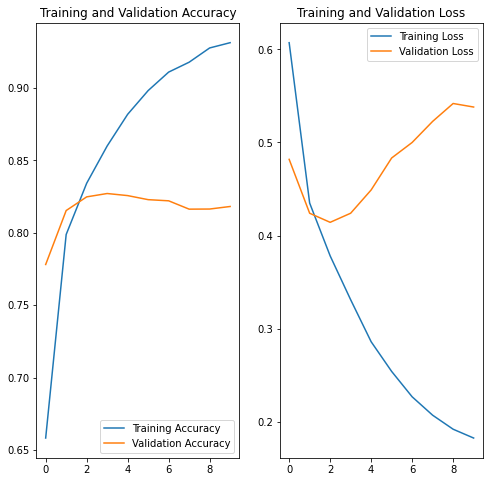

In [18]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
